# K-Means Background Removal for Image Segmentation

In this notebook we will experiment with the k-means algorithm as a preprocessing step for image classification models. The goal is to remove the background from images in order to improve the performance of the classification model. We will use the [DUTS dataset](https://kaggle.com/datasets/balraj98/duts-saliency-detection-dataset) for our experiments. The dataset contains images of various objects with their corresponding segmentation masks.

Our score function will be the Intersection over Union (IoU) between the predicted mask and the ground truth mask.

The notebook was created by Marcus Piitala, Gustav Jensen, Anes Alkaisi and Peter Dall-Hansen as part of the course Introduction to Intelligent Systems at DTU.




In [10]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage import img_as_ubyte
from skimage.transform import rescale, resize
from skimage.color import rgb2lab, lab2rgb
from sklearn.metrics.pairwise import euclidean_distances
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

np.seterr(divide="ignore", invalid="ignore", over="ignore")
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="skimage")

# Download DUTS dataset

In [11]:
# Download the dataset from kagglehub
base_path = kagglehub.dataset_download("balraj98/duts-saliency-detection-dataset")
base_path = base_path + "/"
print(base_path)


# Read metadata
df = pd.read_csv(base_path + "metadata.csv")
# Drop split column as not neccesary for this lab
df = df.drop(columns=["split"])
df["image_path"] = base_path + df["image_path"]
df["mask_path"] = base_path + df["mask_path"]


# Display first 5 rows
df.head()

/Users/pdh/.cache/kagglehub/datasets/balraj98/duts-saliency-detection-dataset/versions/1/


,image_id,image_path,mask_path
0,ILSVRC2012_test_00000003,/Users/pdh/.cache/kagglehub/datasets/balraj98/...,/Users/pdh/.cache/kagglehub/datasets/balraj98/...
1,ILSVRC2012_test_00000004,/Users/pdh/.cache/kagglehub/datasets/balraj98/...,/Users/pdh/.cache/kagglehub/datasets/balraj98/...
2,ILSVRC2012_test_00000018,/Users/pdh/.cache/kagglehub/datasets/balraj98/...,/Users/pdh/.cache/kagglehub/datasets/balraj98/...
3,ILSVRC2012_test_00000019,/Users/pdh/.cache/kagglehub/datasets/balraj98/...,/Users/pdh/.cache/kagglehub/datasets/balraj98/...
4,ILSVRC2012_test_00000022,/Users/pdh/.cache/kagglehub/datasets/balraj98/...,/Users/pdh/.cache/kagglehub/datasets/balraj98/...


# Preview dataset

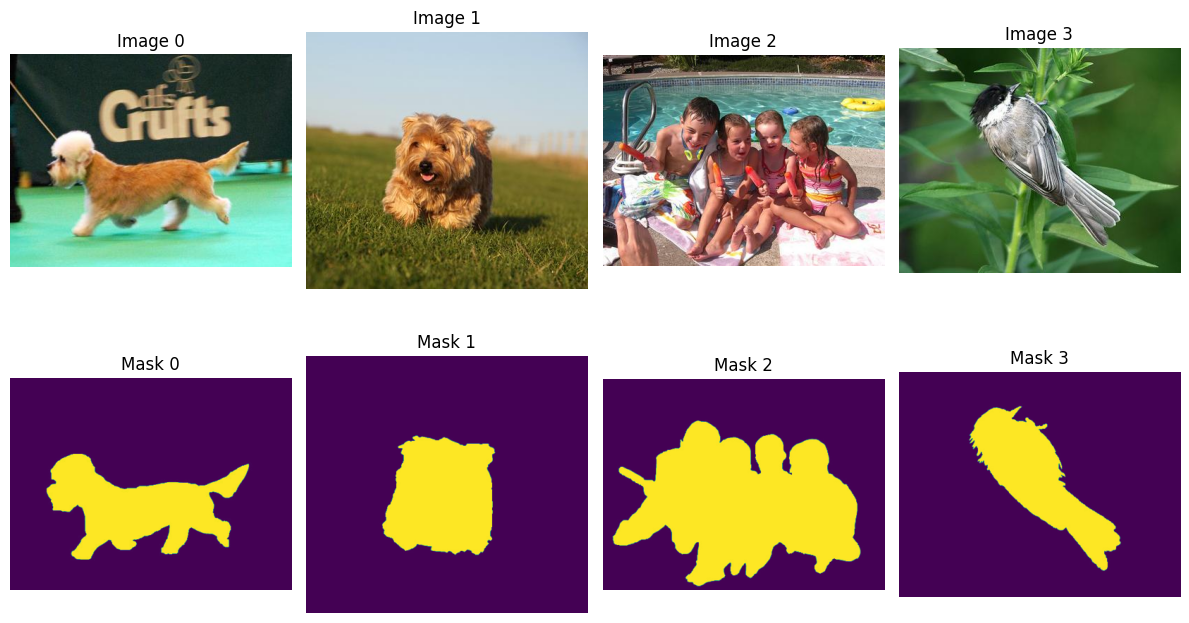

In [12]:
n = 4 # Number of samples
fig, axes = plt.subplots(2, n, figsize=(3 * n, 7))

for i in range(n):
    img_path = df.loc[i, "image_path"]
    mask_path = df.loc[i, "mask_path"]

    # Loading images
    img = imread(img_path)
    mask = imread(mask_path)

    # Plot images and masks
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Image {i}")
    axes[0, i].axis("off")

    axes[1, i].imshow(mask)
    axes[1, i].set_title(f"Mask {i}")
    axes[1, i].axis("off")


plt.tight_layout()
plt.show()

# Prepare functions to remove background

In [13]:
def cluster_assignments(X, Y):
    return np.argmin(euclidean_distances(X, Y), axis=1)


def Kmeans(data, K = 3):
    centers = np.array([data.mean(0) + (np.random.randn(3)/10) for _ in range(K)])
    y_kmeans = cluster_assignments(data,centers)

    # repeat estimation a number of times (could do something smarter, like comparing if clusters change)
    for _ in range(30):
        y_kmeans = cluster_assignments(data, centers)
        for j, c in enumerate(centers):
            points = data[y_kmeans == j]
            if len(points):
                centers[j] = points.mean(0)

    return centers, y_kmeans


def remove_background(image_path: str, output_path: str):
    image_raw = imread(image_path)
    image_width = 100
    image = rescale(
        image_raw,
        image_width / image_raw.shape[0],
        mode="reflect",
        channel_axis=2,
        anti_aliasing=True,
    )
    shape = image.shape
    image_pixels_lab = rgb2lab(image).reshape(-1, 3)
    centers, y_kmeans = Kmeans(image_pixels_lab, K=3)

    cluster_map = y_kmeans.reshape(shape[0], shape[1])

    # Go through first column, last column, first row and last row
    # # and get count of each clusters
    border_labels = np.concatenate(
        [
            cluster_map[0, :],
            cluster_map[-1, :],
            cluster_map[:, 0],
            cluster_map[:, -1],
        ]
    )
    unique, counts = np.unique(border_labels, return_counts=True)
    border_counts = dict(zip(unique, counts))

    # Remove the two clusters that are touching the border of the image the most
    bg_clusters = sorted(border_counts, key=border_counts.get, reverse=True)[:2]

    # create a mask keeping only non-background clusters
    mask = ~np.isin(cluster_map, bg_clusters)

    img_lab = centers[y_kmeans].reshape(shape)
    img_rgb = lab2rgb(img_lab)

    # Here we match the background color and foreground color to the dataset (purple and yellow)
    bg_color = np.array([68, 1, 84]) / 255.0
    fg_color = np.array([253, 231, 36]) / 255.0

    # Then we apply the mask and set the colors
    img_rgb[:] = bg_color 
    img_rgb[mask] = fg_color  

    img_uint8 = img_as_ubyte(img_rgb)

    # Create output directory if it doesnt exist
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    imsave(output_path, img_uint8)
    return output_path

In [14]:
from joblib import Parallel, delayed
from tqdm import tqdm
import os
from pathlib import Path

OVERWRITE = False
base_output_dir = Path(base_path) / "processed"
base_output_dir.mkdir(parents=True, exist_ok=True)


# Here we create a function that processes a row from our dataframe
def process_image(index, path):
    try:
        output_path = base_output_dir / f"{index}.png"
        if not output_path.exists() or OVERWRITE:
            remove_background(str(path), str(output_path))
        return str(output_path)
    except Exception as e:
        return f"ERROR: {e}"


# To increase the speed we will use multithreading
# Might be overkill for this task but it sure does increase the speed :)
results = Parallel(n_jobs=os.cpu_count(), backend="loky")(
    delayed(process_image)(i, p)
    for i, p in tqdm(
        enumerate(df["image_path"]), total=len(df), desc="Processing Images"
    )
)

df["processed_path"] = results

Processing Images: 100%|██████████| 15572/15572 [00:00<00:00, 79673.01it/s]


# Preview processed images

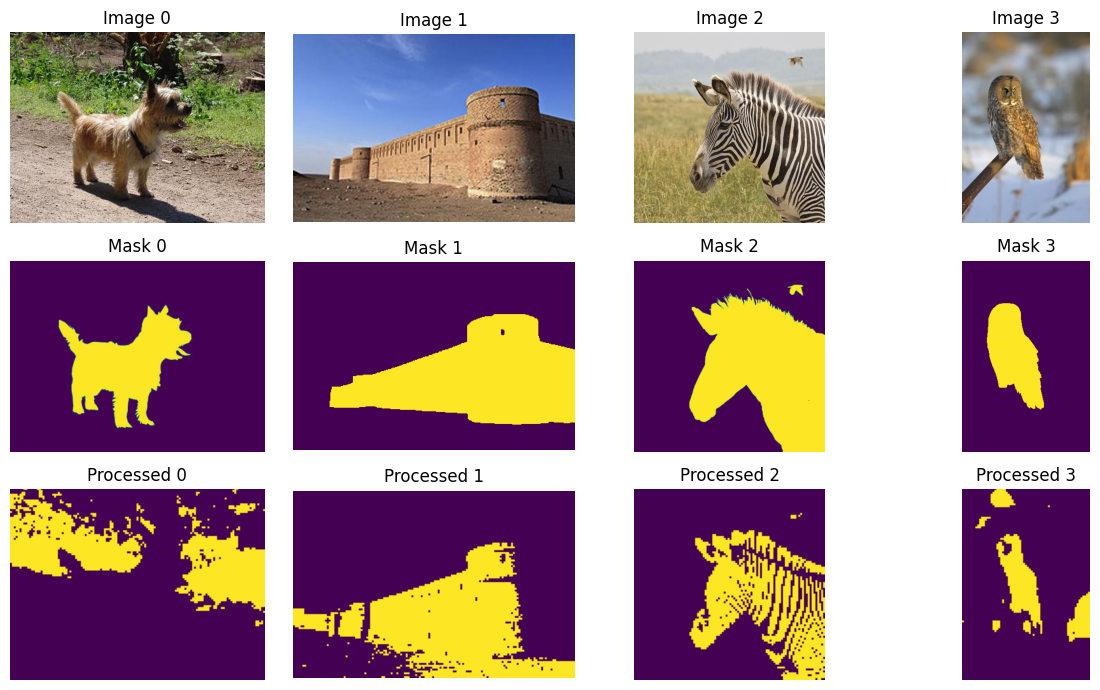

In [15]:
rows = df.sample(4)
fig, axes = plt.subplots(3, n, figsize=(3 * n, 7))

for i, (_, row) in enumerate(rows.iterrows()):

    img_path = row["image_path"]
    mask_path = row["mask_path"]
    processed_path = row["processed_path"]

    # Loading images
    img = imread(img_path)
    mask = imread(mask_path)
    processed = imread(processed_path)

    # Plot images and masks
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Image {i}")
    axes[0, i].axis("off")

    axes[1, i].imshow(mask)
    axes[1, i].set_title(f"Mask {i}")
    axes[1, i].axis("off")

    axes[2, i].imshow(processed)
    axes[2, i].set_title(f"Processed {i}")
    axes[2, i].axis("off")


plt.tight_layout()
plt.show()

# Compare our clustering method with ground truth masks

In [ ]:
paths = df["image_path"]

# Iterate over all images in dataset and apply kmeans background removal
# Save processed image file path to dataframe
ious = []
for index, path in enumerate(tqdm(paths, desc="Processing Images")):
    kmeans_image = imread(base_path + f"processed/{index}.png")
    mask_image = imread(df.loc[i, "mask_path"])

    # Rescale mask image to same scale as our image
    mask_image = resize(
        mask_image,
        kmeans_image.shape[:2],  # match height & width exactly
        anti_aliasing=False,
        preserve_range=True,
    )
    kmeans_image = kmeans_image.mean(axis=2)

    # Normalize both to [0, 1]
    kmeans_image = kmeans_image / 255.0 if kmeans_image.max() > 1 else kmeans_image
    mask_image = mask_image / 255.0 if mask_image.max() > 1 else mask_image

    # Threshold to create binary masks
    kmeans_binary = kmeans_image > 0.5
    mask_binary = mask_image > 0.5

    # Compute IoU
    intersection = np.logical_and(kmeans_binary, mask_binary).sum()
    union = np.logical_or(kmeans_binary, mask_binary).sum()

    iou = intersection / union if union != 0 else 0
    ious.append(iou)

df["iou"] = ious

Processing Images: 100%|██████████| 15572/15572 [00:27<00:00, 571.50it/s]


# Statistics

In [21]:
df["iou"].describe()

count    15572.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: iou, dtype: float64

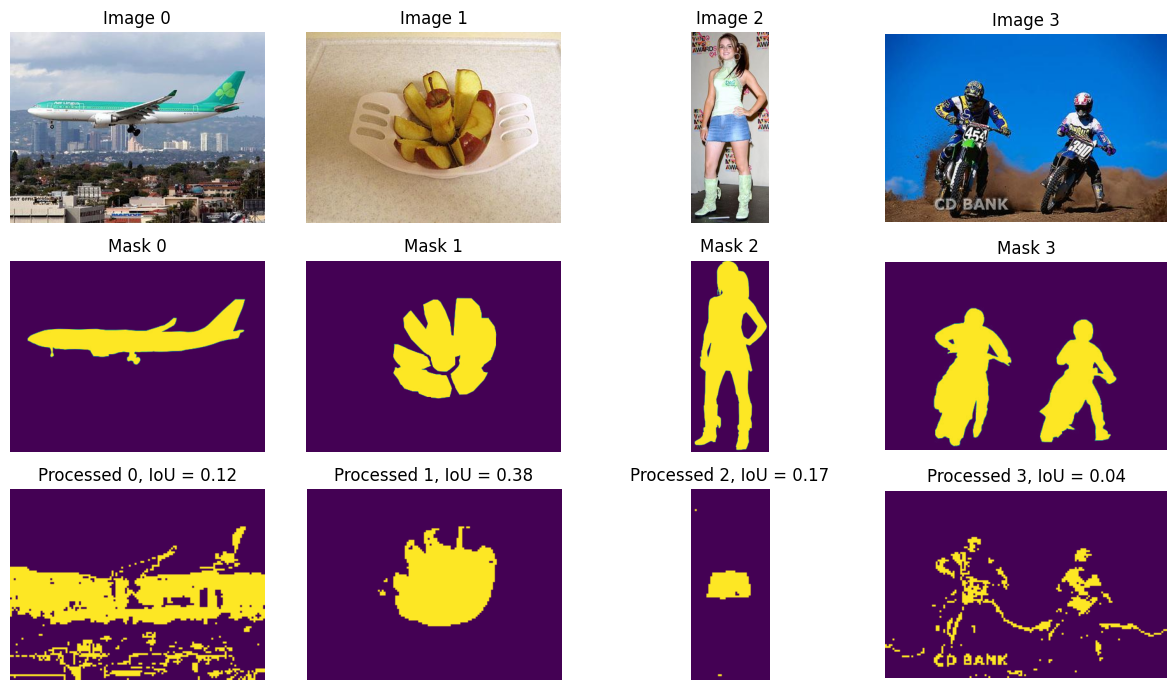

In [18]:
rows = df.sample(4)
fig, axes = plt.subplots(3, n, figsize=(3 * n, 7))

for i, (_, row) in enumerate(rows.iterrows()):

    img_path = row["image_path"]
    mask_path = row["mask_path"]
    processed_path = row["processed_path"]
    iou = row["iou"]

    # Loading images
    img = imread(img_path)
    mask = imread(mask_path)
    processed = imread(processed_path)

    # Plot images and masks
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Image {i}")
    axes[0, i].axis("off")

    axes[1, i].imshow(mask)
    axes[1, i].set_title(f"Mask {i}")
    axes[1, i].axis("off")

    axes[2, i].imshow(processed)
    axes[2, i].set_title(f"Processed {i}, IoU = {round(iou, 2)}")
    axes[2, i].axis("off")


plt.tight_layout()
plt.show()